# Longitudinal Analysis

### Import packages

In [1]:
import paramiko
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from leaspy import Leaspy, Data, AlgorithmSettings, IndividualParameters

### SSH Connection + file read

In [2]:
hostname = 'bridges2.psc.edu'
username = 'amanov'
password = '110388+neuro'

remote_path_baseline_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/baseline/trks/mean length(mm).csv'
remote_path_2yr_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/2yrfollowup/trks/mean length(mm).csv'
remote_path_4yr_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/4yrfollowup/trks/mean length(mm).csv'

client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, username=username, password=password)
print('SSH connection established')

sftp = client.open_sftp()

print('reading requested files')
    
with sftp.open(remote_path_baseline_mm, 'r') as remote_file:
    csv_content_baseline_mm = remote_file.read()

with sftp.open(remote_path_2yr_mm, 'r') as remote_file:
    csv_content_2yr_mm = remote_file.read()

with sftp.open(remote_path_4yr_mm, 'r') as remote_file:
    csv_content_4yr_mm = remote_file.read()

print('files read')

sftp.close()
client.close()
print('SSH connection closed')


SSH connection established
reading requested files
files read
SSH connection closed


### Dataframe modification

In [3]:
data_baseline = pd.read_csv(StringIO(csv_content_baseline_mm.decode('utf-8')))
data_2yr = pd.read_csv(StringIO(csv_content_2yr_mm.decode('utf-8')))
data_4yr = pd.read_csv(StringIO(csv_content_4yr_mm.decode('utf-8')))

data_baseline.rename(columns={data_baseline.columns[0]: 'ID'}, inplace=True)
data_2yr.rename(columns={data_2yr.columns[0]: 'ID'}, inplace=True)
data_4yr.rename(columns={data_4yr.columns[0]: 'ID'}, inplace=True)

In [4]:
data_baseline.insert(1, 'TIME', 'baseline')
data_2yr.insert(1, 'TIME', '2yr')
data_4yr.insert(1, 'TIME', '4yr')

data_baseline['TIME'] = 0
data_2yr['TIME'] = 2
data_4yr['TIME'] = 4

combined_data = pd.concat([data_baseline, data_2yr, data_4yr], ignore_index=True)

In [5]:
demographics = pd.read_csv('/Users/armanimanov/Downloads/abcd_p_demo.csv')

combined_data['ID'] = combined_data['ID'].str.replace('sub-', '')

In [6]:
#rename column
demographics.rename(columns={'src_subject_id': 'ID'}, inplace=True)

In [8]:
demographics['ID'] = demographics['ID'].str.replace('NDAR_', 'NDAR')


In [9]:
demographics = demographics.drop_duplicates(subset='ID', keep='first')

In [10]:
combined_data = pd.merge(combined_data, demographics[['ID', 'demo_sex_v2']], on='ID', how='left')

In [17]:
#exclude subjects with 3.0 in demo_sex_v2
combined_data = combined_data[combined_data['demo_sex_v2'] != 3.0]

### The next 2 code cells are **mutually exclusive**. Only choose one code cell to run before creating plot.
_________

OPTION 1: <span style="color:red;">Run code cell below for **FULL** dataset</span>

In [ ]:
#insert new column after ID column
combined_data = pd.concat([data_baseline, data_2yr, data_4yr], ignore_index=True)

In [ ]:
combined_data.to_csv('/Users/armanimanov/Desktop/neurosurg/combined_data_longitudinal.csv', index=False)

OPTION 2: <span style="color:red;">Run code cell below for **n=X sampled** dataset</span>

In [ ]:
sampled_baseline = data_baseline.sample(n=100, random_state=42)
sampled_2yr = data_2yr[data_2yr['ID'].isin(sampled_baseline['ID'])]
sampled_4yr = data_4yr[data_4yr['ID'].isin(sampled_baseline['ID'])]

sampled_baseline['TIME'] = 0
sampled_2yr['TIME'] = 2
sampled_4yr['TIME'] = 4

combined_data = pd.concat([sampled_baseline, sampled_2yr, sampled_4yr], ignore_index=True)

__________

In [ ]:
duplicates = combined_data.duplicated(subset=['ID', 'TIME'], keep=False)
print(duplicates)
#data = combined_data.drop_duplicates(subset=['ID', 'TIME'], keep='first')
#print(data)

In [ ]:
df = combined_data

robust_min = df.iloc[:, 2:].quantile(0.01)
robust_max = df.iloc[:, 2:].quantile(0.99)

df.iloc[:, 2:] = (df.iloc[:, 2:] - robust_min) / (robust_max - robust_min)

df.iloc[:, 2:] = df.iloc[:, 2:].clip(lower=0, upper=1)

fts_min_max = df.iloc[:, 2:].agg(['min', 'max'])

assert (fts_min_max.loc['min'] >= 0).all(), "Some minimum values are below 0."
assert (fts_min_max.loc['max'] <= 1).all(), "Some maximum values are above 1."

pd.options.display.float_format = '{:.2f}'.format

data = Data.from_dataframe(df) 
fts_min_max


In [ ]:
algo_settings = AlgorithmSettings('mcmc_saem', 
                                  n_iter=1,           # n_iter defines the number of iterations
                                  progress_bar=True)     # To display a nice progression bar during calibration

algo_settings.set_logs(
    path='outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    save_periodicity=50, # Saves the values in csv files every N iterations
    console_print_periodicity=100, # Displays logs in the console/terminal every N iterations, or None
    plot_periodicity=1000, # Generates the convergence plots every N iterations
    overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
)

leaspy = Leaspy("logistic", 
                source_dimension=15, # Optional
                noise_model='gaussian_diagonal', # Optional: To get a noise estimate per feature keep it this way (default)
                )

In [ ]:
leaspy.fit(data, settings=algo_settings)

In [ ]:
# —— get avg individual parameters
mean_xi = leaspy.model.parameters['xi_mean'].numpy()
mean_tau = leaspy.model.parameters['tau_mean'].numpy()
mean_source = leaspy.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— store avg individual parameters in dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)

In [ ]:
cmap = plt.cm.get_cmap('viridis', 110)
colors = [cmap(i) for i in range(110)]

In [ ]:
timepoints = np.linspace(0, 4)
values = leaspy.estimate({'average': timepoints}, ip_average)

def plot_trajectory(timepoints, reconstruction, observations=None, *, 
                    xlabel='Timepoints', ylabel='Normalized feature value'):
    
    plt.figure(figsize=(15, 8))
    plt.ylim(0.3, 0.8)
    
    if observations is not None:
        ages = observations.index.values
    
    for i, (name, val) in enumerate(zip(leaspy.model.features, reconstruction.T)):
        plt.plot(timepoints, val, label=name, c=colors[i], linewidth=2)
        if observations is not None:
            plt.plot(ages, observations[name], c=colors[i], marker='o', markersize=5, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

plot_trajectory(timepoints, values['average'])

In [13]:
combined_data

,ID,TIME,Association_ArcuateFasciculusL,Association_ArcuateFasciculusR,Association_CingulumL_FrontalParahippocampal,Association_CingulumL_FrontalParietal,Association_CingulumL_SuperiorLongitudinalFasciculus1,Association_CingulumL_ParahippocampalParietal,Association_CingulumL_Parahippocampal,Association_CingulumL_Parolfactory,...,CranialNerve_CNIIR,CranialNerve_CNIIIL,CranialNerve_CNIIIR,CranialNerve_CNVL,CranialNerve_CNVR,CranialNerve_CNVIIL,CranialNerve_CNVIIR,CranialNerve_CNVIIIL,CranialNerve_CNVIIIR,demo_sex_v2
0,NDARINVM0JXYXX1,0,108.535,99.4989,98.4810,104.399,71.2545,72.9126,63.0870,67.5052,...,52.2233,46.8555,31.6981,37.8056,31.9145,22.4299,24.9829,38.9319,42.7818,2.0
1,NDARINVZ4KYLWJA,0,118.503,117.5860,110.7280,118.692,90.5630,75.7324,70.9184,69.2089,...,51.8124,42.6027,54.1694,41.0266,36.5136,25.6260,25.5314,35.6880,34.8250,2.0
2,NDARINVUYYEU9U1,0,126.825,132.1760,119.5420,125.095,85.2098,81.7812,71.6001,80.2633,...,52.2988,42.1942,47.5582,32.2760,29.8719,28.1467,27.4157,33.7604,36.6265,1.0
3,NDARINV0BAVEL0T,0,127.088,135.7320,106.6930,117.557,83.5401,74.0580,69.5191,75.4894,...,47.6526,43.4528,41.5940,34.5012,34.8833,31.5007,30.6800,36.0786,40.2994,1.0
4,NDARINV5C2HRHM2,0,123.508,130.3830,112.5470,105.636,76.2524,67.9281,61.5049,71.2010,...,56.6712,32.2144,28.2802,39.8906,34.5299,22.1669,26.2023,42.4457,40.2140,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19641,NDARINVZ2E8YJN2,4,120.876,118.3950,98.7099,104.551,80.1930,77.8534,70.1827,61.9659,...,39.8783,42.8934,49.5059,34.2414,29.1059,26.0636,26.3925,32.6536,34.6978,1.0
19642,NDARINVY6M92H2Y,4,123.439,121.5170,108.8150,122.467,79.5609,79.0357,70.9669,78.7156,...,43.3267,29.8067,31.3438,39.0367,44.9405,34.7678,30.4176,44.0113,39.2355,1.0
19643,NDARINV6CG6LPAT,4,116.650,104.6330,106.7270,112.952,70.5079,67.7322,58.7923,83.6579,...,53.3037,38.2500,39.2327,33.6864,30.1524,26.1886,28.9472,29.8009,27.9214,2.0
19644,NDARINVRGVY0VAU,4,111.151,112.3430,102.8890,103.300,70.5638,79.1282,62.6070,67.3420,...,45.4079,49.6050,41.3354,41.2607,29.9120,32.6230,30.7437,41.4053,32.8215,2.0


<Axes: xlabel='TIME', ylabel='Association_ArcuateFasciculusL'>

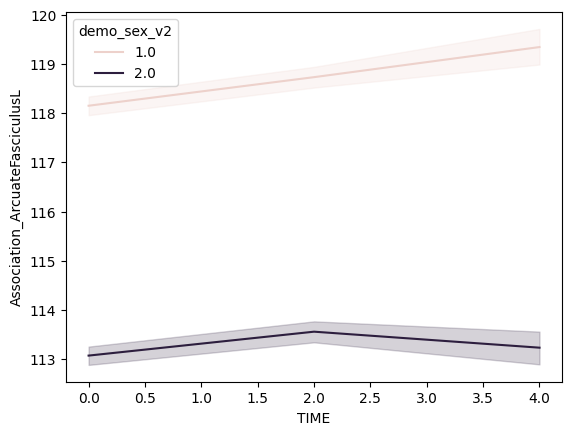

In [18]:
import seaborn as sns
sns.lineplot(x="TIME", y="Association_ArcuateFasciculusL", hue="demo_sex_v2", data=combined_data)

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.ols(formula='Association_ArcuateFasciculusL ~ TIME * demo_sex_v2', data=combined_data)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Association_ArcuateFasciculusL   R-squared:                       0.136
Model:                                        OLS   Adj. R-squared:                  0.136
Method:                             Least Squares   F-statistic:                     1034.
Date:                            Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                                    11:44:08   Log-Likelihood:                -65158.
No. Observations:                           19641   AIC:                         1.303e+05
Df Residuals:                               19637   BIC:                         1.304e+05
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----